# Box Blur using CUDA

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-jfxty1bn
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-jfxty1bn
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-c6hfvsrn/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


In [ ]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpzjk3padk".


In [ ]:
%%writefile box_blur.cu

#include <png.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

// Kernel to apply a 3x3 box blur filter using shared memory
__global__ void boxBlurKernelShared(unsigned char* d_in, unsigned char* d_out, int width, int height, int channels) {
    extern __shared__ unsigned char shared_mem[];
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int tx = threadIdx.x + 1;
    int ty = threadIdx.y + 1;

    // Load the pixel into shared memory (center)
    for (int c = 0; c < channels; ++c) {
        int sharedIdx = (ty * (blockDim.x + 2) + tx) * channels + c;
        int globalIdx = (y * width + x) * channels + c;
        shared_mem[sharedIdx] = (x < width && y < height) ? d_in[globalIdx] : 0;
    }

    // Load borders (edge cases)
    if (threadIdx.x == 0 && x > 0) {
        for (int c = 0; c < channels; ++c) {
            shared_mem[(ty * (blockDim.x + 2)) * channels + c] = (y < height) ? d_in[((y * width) + (x - 1)) * channels + c] : 0;
        }
    }

    if (threadIdx.x == blockDim.x - 1 && x < width - 1) {
        for (int c = 0; c < channels; ++c) {
            shared_mem[(ty * (blockDim.x + 2) + (blockDim.x + 1)) * channels + c] = (y < height) ? d_in[((y * width) + (x + 1)) * channels + c] : 0;
        }
    }

    if (threadIdx.y == 0 && y > 0) {
        for (int c = 0; c < channels; ++c) {
            shared_mem[tx * channels + c] = (x < width) ? d_in[((y - 1) * width + x) * channels + c] : 0;
        }
    }

    if (threadIdx.y == blockDim.y - 1 && y < height - 1) {
        for (int c = 0; c < channels; ++c) {
            shared_mem[((blockDim.y + 1) * (blockDim.x + 2) + tx) * channels + c] = (x < width) ? d_in[((y + 1) * width + x) * channels + c] : 0;
        }
    }

    __syncthreads();

    // Apply the box blur
    if (x < width && y < height) {
        for (int c = 0; c < channels; ++c) {
            int sum = 0;
            for (int dy = -1; dy <= 1; ++dy) {
                for (int dx = -1; dx <= 1; ++dx) {
                    int sharedIdx = ((ty + dy) * (blockDim.x + 2) + (tx + dx)) * channels + c;
                    sum += shared_mem[sharedIdx];
                }
            }
            int outputIdx = (y * width + x) * channels + c;
            d_out[outputIdx] = sum / 9;
        }
    }
}

// Function to read an image from a PNG file using libpng
unsigned char* readPNG(const char* filename, int* width, int* height, int* channels) {
    FILE* fp = fopen(filename, "rb");
    if (!fp) {
        perror("Error opening file");
        return NULL;
    }

    png_structp png = png_create_read_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png) {
        fclose(fp);
        return NULL;
    }

    png_infop info = png_create_info_struct(png);
    if (!info) {
        png_destroy_read_struct(&png, NULL, NULL);
        fclose(fp);
        return NULL;
    }

    if (setjmp(png_jmpbuf(png))) {
        png_destroy_read_struct(&png, &info, NULL);
        fclose(fp);
        return NULL;
    }

    png_init_io(png, fp);
    png_read_info(png, info);

    *width = png_get_image_width(png, info);
    *height = png_get_image_height(png, info);
    *channels = png_get_channels(png, info);

    png_bytep* row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * (*height));
    unsigned char* data = (unsigned char*)malloc((*width) * (*height) * (*channels));

    for (int y = 0; y < *height; ++y) {
        row_pointers[y] = data + y * (*width) * (*channels);
    }

    png_read_image(png, row_pointers);
    free(row_pointers);
    png_destroy_read_struct(&png, &info, NULL);
    fclose(fp);

    return data;
}

// Function to write an image to a PNG file using libpng
void writePNG(const char* filename, unsigned char* data, int width, int height, int channels) {
    FILE* fp = fopen(filename, "wb");
    if (!fp) {
        perror("Error opening file");
        return;
    }

    png_structp png = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png) {
        fclose(fp);
        return;
    }

    png_infop info = png_create_info_struct(png);
    if (!info) {
        png_destroy_write_struct(&png, NULL);
        fclose(fp);
        return;
    }

    if (setjmp(png_jmpbuf(png))) {
        png_destroy_write_struct(&png, &info);
        fclose(fp);
        return;
    }

    png_init_io(png, fp);

    png_set_IHDR(png, info, width, height, 8, PNG_COLOR_TYPE_RGB, PNG_INTERLACE_NONE,
                 PNG_COMPRESSION_TYPE_DEFAULT, PNG_FILTER_TYPE_DEFAULT);

    png_bytep* row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * height);
    for (int y = 0; y < height; ++y) {
        row_pointers[y] = data + y * width * channels;
    }

    png_set_rows(png, info, row_pointers);
    png_write_png(png, info, PNG_TRANSFORM_IDENTITY, NULL);

    free(row_pointers);
    png_destroy_write_struct(&png, &info);
    fclose(fp);
}

int main(int argc, char** argv) {
    if (argc != 2) {
        fprintf(stderr, "Usage: %s <input_image.png>\n", argv[0]);
        return 1;
    }

    const char* inputFile = argv[1];
    const char* outputFile = "blurred_image.png";

    // Read the input image
    int width, height, channels;
    unsigned char* h_in = readPNG(inputFile, &width, &height, &channels);
    if (!h_in) {
        fprintf(stderr, "Error reading image file '%s'\n", inputFile);
        return 1;
    }

    // Ensure it's an RGB image
    if (channels < 3) {
        fprintf(stderr, "Unsupported image format\n");
        free(h_in);
        return 1;
    }

    // Allocate memory for the blurred image
    unsigned char* h_out = (unsigned char*)malloc(width * height * channels);

    // Allocate GPU memory
    unsigned char *d_in, *d_out;
    cudaMalloc(&d_in, width * height * channels);
    cudaMalloc(&d_out, width * height * channels);

    // Copy input image to the GPU
    cudaMemcpy(d_in, h_in, width * height * channels, cudaMemcpyHostToDevice);

    // Configure grid and block sizes
    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);
    size_t sharedMemSize = (blockSize.x + 2) * (blockSize.y + 2) * channels;

    // Launch the box blur kernel with shared memory
    boxBlurKernelShared<<<gridSize, blockSize, sharedMemSize>>>(d_in, d_out, width, height, channels);

    // Copy the blurred image back to the host
    cudaMemcpy(h_out, d_out, width * height * channels, cudaMemcpyDeviceToHost);

    // Write the blurred image to a PNG file
    writePNG(outputFile, h_out, width, height, channels);

    // Cleanup
    cudaFree(d_in);
    cudaFree(d_out);
    free(h_in);
    free(h_out);

    printf("Box blur applied and saved to '%s'.\n", outputFile);
    return 0;
}


Writing box_blur.cu


In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_and_save_image(image_url, output_filename):

    response = requests.get(image_url)
    response.raise_for_status()

    image_data = BytesIO(response.content)
    image = Image.open(image_data)

    image.save(output_filename)
    print(f"Image saved to '{output_filename}'")


image_url = "https://thumbor.bigedition.com/jaguar/VWxv4olA9_Ue_mWc3Vm6XEO9SbU=/0x0:1113x835/800x0/filters:quality(80)/granite-web-prod/5d/95/5d95b72831e54edb84753e9c5e1b6157.jpeg"
output_filename = "input_image.png"
download_and_save_image(image_url, output_filename)


Image saved to 'input_image.png'


In [ ]:
!nvcc -o box_blur box_blur.cu -lpng


In [ ]:
!./box_blur 'input_image.png'

Box blur applied and saved to 'blurred_image.png'.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


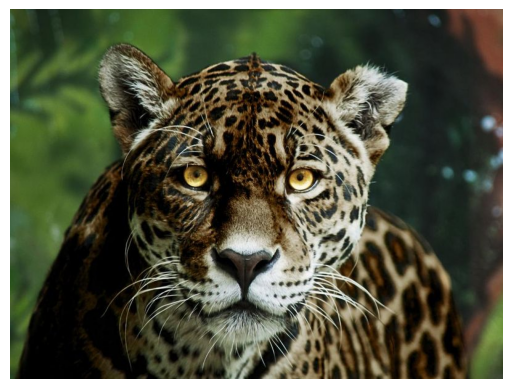

In [ ]:
image_path = 'input_image.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()


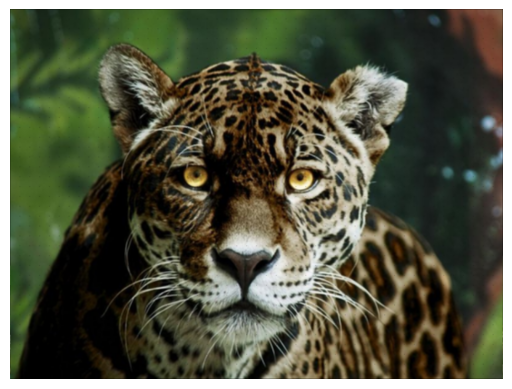

In [ ]:
blur_image_path = 'blurred_image.png'
blur_img = Image.open(blur_image_path)

plt.imshow(blur_img)
plt.axis('off')
plt.show()